In [13]:
""" Quick analizer for the station 0-20000-0-10962 
      focus on the date '2014-12-10T06:00:00.000000000', '2014-12-10T06:00:28.000000000' 
      i.e. two distinct records only 28 seconds apart.
      This originates from the merging of NCAR and ERA5 data """

import xarray as xr
import netCDF4 as nc
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import ticker
import os,sys
import matplotlib.pylab as plt

%matplotlib inline
%pylab inline

#matplotlib.use('Agg')

Populating the interactive namespace from numpy and matplotlib


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [14]:
""" Load CSV data directly from ERA5 odb """
df = pd.read_csv('all_odb_data_10962.txt', sep ='\t')
df_red = df.loc [ df['time@hdr'] == 60000  ]
era5_temp = df_red.dropna()


In [15]:

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)


out_dir = 'Plots/TimeShifts/'
os.system('mkdir ' + out_dir )


""" Files list """
merged = '/raid60/scratch/federico/JULY_MERGE/0-20000-0-10962_CEUAS_merged_v0.nc' 
era5   = '/raid60/scratch/federico/HARVESTED_JULY2020/era5_1/0-20000-0-10962_era5_1_harvested_era5.conv.??????.10962.txt.gz.nc'
ncar   = '/raid60/scratch/federico/HARVESTED_JULY2020/ncar/0-20000-0-10962_ncar_harvested_uadb_trhc_10962.txt.nc'
igra   = '/raid60/scratch/federico/HARVESTED_JULY2020/igra2/0-20000-0-10962_igra2_harvested_GMM00010962-data.txt.nc'


""" Loading the observations table """
################## observations_table indices = ot_era5[3935484:3935694] 
ot_era5 = xr.open_dataset (era5, engine = 'h5netcdf'  , group = "observations_table", decode_times = True ).to_dataframe()
ot_era5 = ot_era5 [ [ "date_time" , "z_coordinate","z_coordinate_type", "observed_variable" , "observation_value" , "source_id" , "report_id" ] ]
dt_era5 = xr.open_dataset(era5, engine = 'h5netcdf' , decode_times = True )['recordtimestamp'] # found in [3831:3832] 
ri_era5 = xr.open_dataset(era5, engine = 'h5netcdf' , decode_times = True )['recordindex']

################## dt_ncar[2465:2466] , ot_ncar[812950:812960] 
ot_ncar = xr.open_dataset (ncar, engine = 'h5netcdf'  , group = "observations_table", decode_times = True ).to_dataframe()
ot_ncar = ot_ncar [ [ "date_time" , "z_coordinate","z_coordinate_type", "observed_variable" , "observation_value" , "source_id" , "report_id" ] ]
dt_ncar = xr.open_dataset(ncar, engine = 'h5netcdf' , decode_times = True )['recordtimestamp']
ri_ncar = xr.open_dataset(ncar, engine = 'h5netcdf' , decode_times = True )['recordindex']

################## dt_igra[3084:3094] ,  ot_igra[1034550:1034570]  
ot_igra = xr.open_dataset (igra, engine = 'h5netcdf'  , group = "observations_table", decode_times = True ).to_dataframe()
ot_igra = ot_igra [ [ "date_time" , "z_coordinate","z_coordinate_type", "observed_variable" , "observation_value" , "source_id" , "report_id" ] ]
dt_igra = xr.open_dataset(igra, engine = 'h5netcdf' , decode_times = True )['recordtimestamp']
ri_igra = xr.open_dataset(igra, engine = 'h5netcdf' , decode_times = True )['recordindex']

################## dt_merged[5578:5590] ot_merged[3302156:3302256] 
ot_merged = xr.open_dataset (merged, engine = 'h5netcdf'  , group = "observations_table", decode_times = True ).to_dataframe()
ot_merged = ot_merged [ [ "date_time" , "z_coordinate","z_coordinate_type", "observed_variable" , "observation_value" , "source_id" , "report_id" ] ]
dt_merged = xr.open_dataset(merged, engine = 'h5netcdf' , decode_times = True )['recordtimestamp']
ri_merged = xr.open_dataset(merged, engine = 'h5netcdf' , decode_times = True )['recordindex']

ht_merged = xr.open_dataset (merged, engine = 'h5netcdf'  , group = "header_table", decode_times = True ).to_dataframe()
ht_merged = ht_merged[['record_timestamp' , 'report_timestamp' , 'report_id', 'duplicates']]


date_time   = ot_merged[3302156:3302256]['date_time'][0]  # 2014-12-10 06:00:00
date_time_2 = ot_merged[3303156:3303256]['date_time'][0]  # 2014-12-10 06:00:00


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


In [132]:
def plot_profile(var = 85):
    
    def get_df(var='', ot = '', date_time = '' ):
        red = ot.loc [  (ot['date_time'] == date_time) &   (ot['observed_variable'] == var)  &   (ot['z_coordinate_type'] == 1) ]
        #print('max p is' , max(red['z_coordinate']) )
        return list(red['observation_value'])[::-1], list(red['z_coordinate']/100)[::-1]
    
    
    def plot(igra_t, igra_p, ncar_t, ncar_p, era5_t, era5_p ):
        from matplotlib import gridspec
        import matplotlib.patches as patches

        fs = 18
        os.system('mkdir output')
        fig = plt.figure( figsize=(20,15))
        fig.suptitle('Profile for the record 2014-12-10 06:00:00, Station 10962 (HOHENPEISSENBERG, Germany)' , y = 0.91, fontsize = fs)
        gs = gridspec.GridSpec(1, 2, width_ratios=[4, 1], figure = fig) 
        ax1 = plt.subplot(gs[0])
        ax2 = plt.subplot(gs[1])

        ax1.tick_params(axis='both', which='major', labelsize=15)
        ax1.tick_params(axis='both', which='minor', labelsize=8)
        w = ax1.invert_yaxis() 
        ax1.set_ylabel( 'Pressure [hPa]'   , fontsize = fs )     
        ax1.set_xlabel( 'Temperature [K]' , fontsize = fs )        
        ax1.grid(ls =":" , color = "lightgray")

        ax1.plot(igra_t, igra_p , label = 'IGRA2'     , color = 'blue')
        ax1.plot(ncar_t, ncar_p , label = 'NCAR'    , color = 'limegreen')
        ax1.plot(era5_t, era5_p , label = 'ERA5 1' , color = 'orange')
        rect = patches.Rectangle( (212,-5), 18, 40 , edgecolor = 'dodgerblue', facecolor = 'None')
        ax1.add_patch(rect)
        ax1.plot([204,212],[525,33] , color = 'dodgerblue', ls = '--')
        ax1.plot([230,255.5],[33,515] , color = 'dodgerblue', ls = '--')

        ax1.legend(loc = 'upper right', fontsize = fs+3)            
        #ax1.set_yscale('log')
        ins = ax1.inset_axes([0.05,0.05,0.7,0.4])
        w = ins.invert_yaxis() 


        limit = 15
        
        igrap = np.array (igra_p)
        igra_indices = list(np.where( igrap <= limit )[0])
        igrap = igrap[igra_indices]
        igra_zoom = np.array(igra_t) [ igra_indices]
        
        
        ncarp = np.array (ncar_p)
        ncar_indices = list(np.where( ncarp <= limit )[0])
        ncarp = ncarp[ncar_indices]
        ncar_zoom = np.array(ncar_t) [ ncar_indices]
        
        erap = np.array (era5_p)
        era_indices = list(np.where( erap <= limit )[0])
        erap = erap[ era_indices]
        era_zoom = np.array(era5_t) [ era_indices]
        
        # SMALL SUBPLOT
        
        ncar_zoom_cleaned , ncarp_cleaned = clean_nans(ncar_zoom, ncarp)
        igra_zoom_cleaned , igrap_cleaned = clean_nans(igra_zoom, igrap)
        
        ins.plot( ncar_zoom_cleaned , ncarp_cleaned , color = 'green' , lw = 2 , ls = ':')
        ins.plot( era_zoom      , erap  , color = 'orange'       , lw = 3 , label = 'ERA5 BUFR')
        ins.plot( igra_zoom_cleaned , igrap_cleaned , color = 'slateblue'      , lw = 1 , ls = '--' )
        
        ins.plot( igra_zoom_cleaned , igrap_cleaned , color = 'slateblue'      , lw = 1 , ls = '--' )
        era5_temp_r = era5_temp.loc [ era5_temp["vertco_reference_1@body"] <= limit*100 ]
        era5_temp_p = [ p/100 for p in era5_temp_r["vertco_reference_1@body"] ]
        ins.scatter(  era5_temp_r["obsvalue@body"] , era5_temp_p, color = 'red'  , s = 70    , lw = 1 , ls = '--' , label = 'ERA5 TEMP')
        ins.scatter( ncar_zoom_cleaned , ncarp_cleaned , color = 'limegreen' ,  s = 50 , label = 'NCAR')
        ins.scatter( igra_zoom_cleaned , igrap_cleaned , color = 'blue'      ,  s = 50 , label = 'IGRA2' , marker = '*')
        ins.grid(ls =":" , color = "dodgerblue")

            
        ins.legend(loc = 'lower right', fontsize = fs-3)    

            
        
        #ins.plot( ncar_zoom    , ncarp , color = 'green')
        #ins.plot( era_zoom     , erap  , color = 'orange' , lw = 1.3)
        #ins.scatter( era_zoom  , erap  , color = 'black'  , s = 5 )
        #ins.plot( igra_zoom    , igrap , color = 'blue')
        
        
        print('NCAR::: ', ncar_zoom, numpy.array(ncarp))
        print('IGRA::: ', igra_zoom, numpy.array(igrap))
        #print('ERA5::: ' , era_zoom, numpy.array(erap))

        ax2.tick_params(axis='both', which='major', labelsize=15)
        ax2.tick_params(axis='both', which='minor', labelsize=8)
        w = ax2.invert_yaxis()      
        
        temp, press = get_diff(igra_t, ncar_t, igra_p, ncar_p)
        print(temp, '\n', press)
        ax2.plot(temp, press, label = 'IGRA2-NCAR'     , color = 'green')
        
        temp, press = get_diff(igra_t, era5_t, igra_p, era5_p)
        ax2.plot(temp, press, label = 'IGRA2-ERA5 1'     , color = 'magenta')
        ax2.grid(ls =":" , color = "lightgray")
        ax2.set_xlabel( 'Temperature Diff. [K]' , fontsize = fs )        
        ax2.legend(loc = 'lower left', fontsize = fs - 2)            
        #ax2.set_ylim([0,30])

        #plt.close()
        plt.savefig(out_dir + '/' + 'time_shifts_profiles.png' ,   bbox_inches = 'tight' , dpi = 250 )
        plt.show()
        plt.close()
        
        
        """ Additional zoom plot """
        fig, ax = plt.subplots( figsize=(20,15))

        w = ax.invert_yaxis() 
        
        ax.tick_params(axis='both', which='major', labelsize=15)
        ax.tick_params(axis='both', which='minor', labelsize=8)
        ax.set_ylabel( 'Pressure [hPa]'   , fontsize = fs )     
        ax.set_xlabel( 'Temperature [K]' , fontsize = fs )  
        ax.grid(ls =":" , color = "lightgray")
        ax.set_xlabel( 'Temperature [K]' , fontsize = fs ) 
        
            


        # ERA5
        ax.plot( ncar_zoom_cleaned , ncarp_cleaned , color = 'green' , lw = 2 , ls = ':')
        ax.plot( era_zoom      , erap  , color = 'orange'       , lw = 3 , label = 'ERA5 BUFR')
        ax.plot( igra_zoom_cleaned , igrap_cleaned , color = 'slateblue'      , lw = 1 , ls = '--' )
        
        ax.plot( igra_zoom_cleaned , igrap_cleaned , color = 'slateblue'      , lw = 1 , ls = '--' )
        era5_temp_r = era5_temp.loc [ era5_temp["vertco_reference_1@body"] <= limit*100 ] # since data is in pascal, plot in hPa 
        era5_temp_p = [ p/100 for p in era5_temp_r["vertco_reference_1@body"] ]
        ax.scatter(  era5_temp_r["obsvalue@body"] , era5_temp_p, color = 'red'  , s = 70    , lw = 1 , ls = '--' , label = 'ERA5 TEMP')
        ax.scatter( ncar_zoom_cleaned , ncarp_cleaned , color = 'limegreen' ,  s = 50 , label = 'NCAR')
        ax.scatter( igra_zoom_cleaned , igrap_cleaned , color = 'blue'      ,  s = 50 , label = 'IGRA2' , marker = '*')

            
        ax.legend(loc = 'lower right', fontsize = fs+2)    

            
        plt.savefig(out_dir + '/' + 'time_shifts_zoom.png' ,   bbox_inches = 'tight' , dpi = 250 )
        plt.show()
        plt.close()
        
            
        
        
    def clean_nans(temp,press):
        """ cleans the vectors from nans """
        clean_v1, clean_v2 = [], []
        
        for a,b in zip(temp,press):
            if np.isnan(a):
                continue
            else:
                clean_v1.append(a)
                clean_v2.append(b)
        return clean_v1, clean_v2 
    
    
        
        
    def get_diff(t_1, t_2, p_1, p_2): # igra_t, era5_t, igra_p, era5_p
        """ Extract the difference of the two vectors """
        diff_t, diff_p = [], []
        for t1,p1 in zip(t_1, p_1 ):
            if p1 in p_2:
                index = p_2.index(p1)
                if np.isnan(t1): continue

                t2 = t_2[index]
                if np.isnan(t2): continue

                diff_t.append(t1-t2)
                diff_p.append(p1)  # append the difference 
        return diff_t, diff_p 
    
    igra_t, igra_p   = get_df ( var=var , ot = ot_igra , date_time=date_time )
    ncar_t, ncar_p   = get_df ( var=var , ot = ot_ncar , date_time=date_time )
    era5_t, era5_p   = get_df ( var=var , ot = ot_era5 , date_time=date_time_2 )
    
    a= plot(igra_t, igra_p, ncar_t, ncar_p, era5_t, era5_p)
    

NCAR:::  [         nan 218.1499939           nan          nan 214.6499939
          nan          nan          nan          nan          nan
 216.05000305 216.6499939           nan 223.05000305          nan
          nan 225.1499939           nan          nan 222.05000305
          nan 226.05000305          nan 223.05000305          nan
          nan          nan          nan 228.1499939 ] [14.5        14.19999981 13.80000019 13.5        12.80000019 12.69999981
 11.60000038 11.10000038 10.80000019 10.39999962 10.10000038 10.
  9.10000038  8.89999962  8.69999981  8.30000019  7.80000019  7.69999981
  7.4000001   7.30000019  6.80000019  6.5999999   5.9000001   5.80000019
  5.5999999   5.30000019  5.0999999   4.9000001   4.9000001 ]
IGRA:::  [         nan 218.25                nan          nan 214.6499939
          nan          nan          nan          nan          nan
 216.05000305 216.6499939           nan 223.05000305          nan
          nan 225.25                nan          nan 222

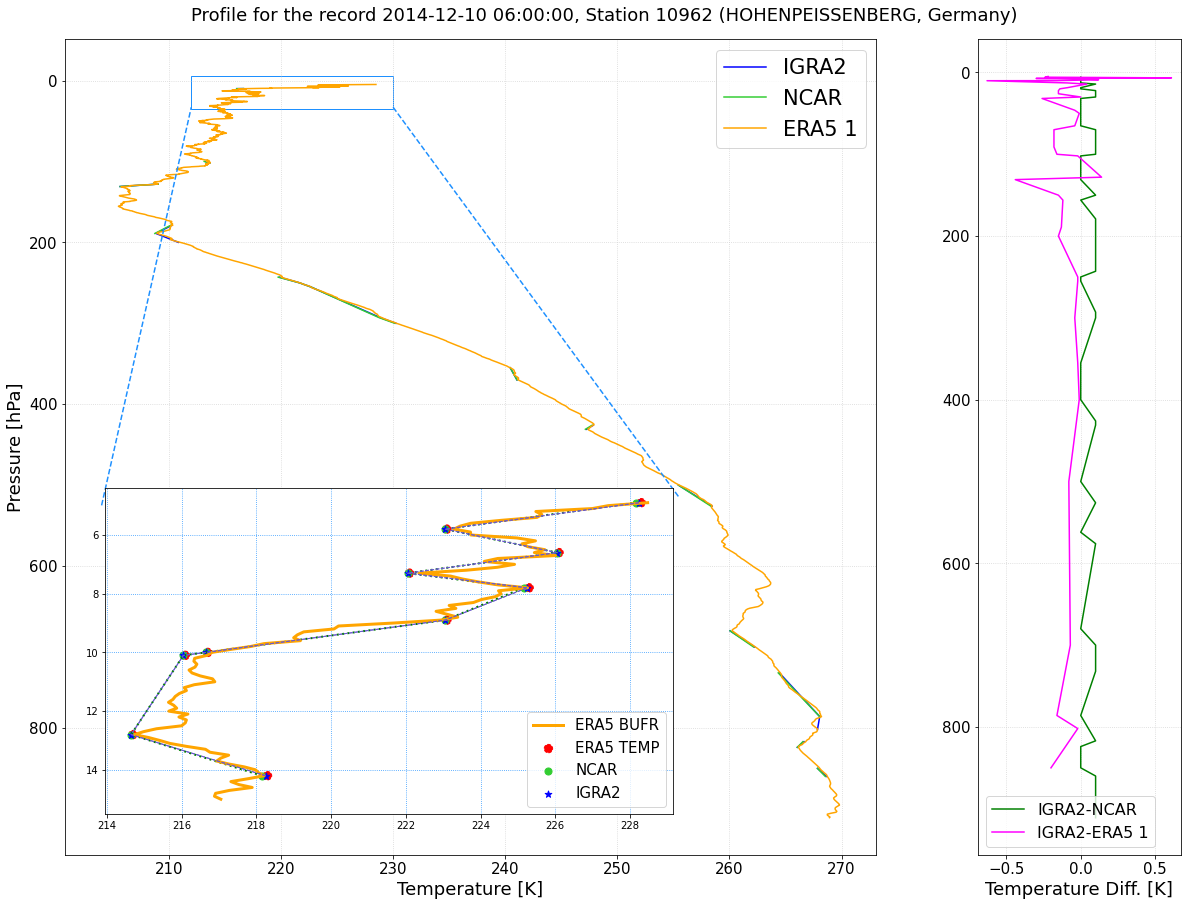

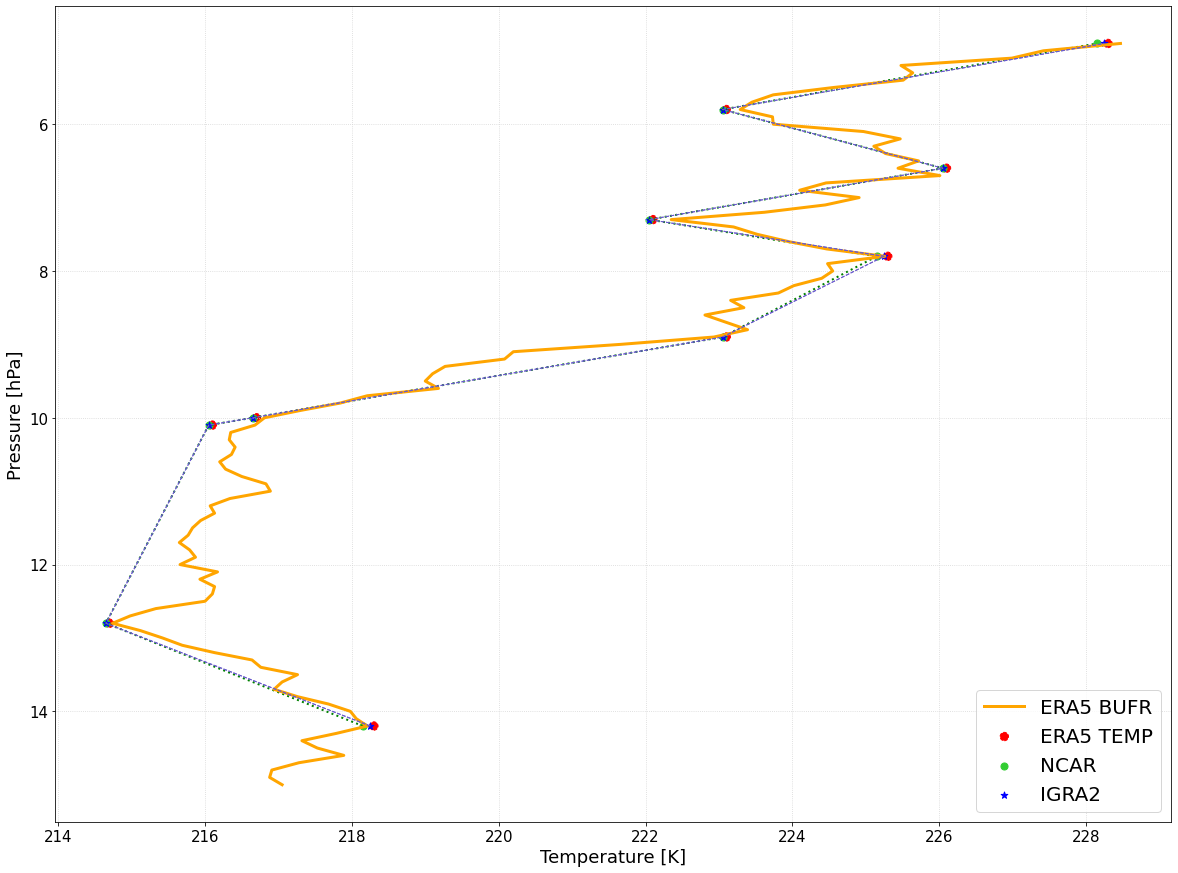

In [133]:
a = plot_profile(var = 85) 